**untitled.ipynb | 2024**
# Motion Matters: Human Fall Detection Classification for Safety Insight
*Agung Malik Ibrahim & Putu Rayno Sebastian*

## Pendahuluan
Jatuh adalah salah satu peristiwa yang sering kali berdampak serius bagi manusia, terutama pada kelompok rentan seperti lansia, pekerja di lingkungan berisiko tinggi, atau individu dengan gangguan mobilitas. Menurut data dari Organisasi Kesehatan Dunia (WHO), jatuh menjadi penyebab utama cedera serius, seperti patah tulang, trauma kepala, hingga kematian dini pada kelompok tertentu. Selain itu, insiden jatuh sering kali menimbulkan rasa takut dan kehilangan kepercayaan diri, yang pada akhirnya dapat menurunkan kualitas hidup. Oleh karena itu, deteksi dini dan akurasi dalam mengenali kejadian jatuh menjadi langkah krusial dalam upaya meningkatkan keselamatan dan memberikan intervensi yang cepat.

Fall detection atau deteksi jatuh adalah teknologi yang memungkinkan identifikasi peristiwa jatuh secara otomatis menggunakan sensor atau analisis data seperti video dan citra. Dengan perkembangan teknologi kecerdasan buatan, khususnya dalam bidang machine learning, deteksi jatuh kini dapat dilakukan dengan lebih cepat dan akurat melalui pemrosesan citra dan pengembangan model klasifikasi berbasis data. Meskipun demikian, teknologi ini masih menghadapi sejumlah tantangan, termasuk kekurangan data yang berkualitas, kesulitan membedakan kejadian jatuh dari aktivitas normal, dan keterbatasan dalam menggeneralisasi model untuk berbagai kondisi dunia nyata.

## Dataset Description
Pada kategori fall, terdapat beberapa jenis gerakan yang termasuk di dalamnya, seperti backward falls, forward falls, left falls, right falls, sitting falls, dan standing falls. Sementara pada kategori non_fall, gerakan yang terdeteksi antara lain jumping, laying, picking, squat, stretching, dan walking. Dalam dataset ini, label 0 digunakan untuk kategori non_fall dan label 1 untuk kategori fall.

- Dataset train terdiri dari 4 subjek dengan berbagai tipe gerakan yang berbeda, dan peserta diharapkan untuk mengembangkan model yang dapat mengklasifikasikan frame-frame video berdasarkan gerakan tersebut
- Data test yang disediakan berisi ribuan frame yang nantinya akan diklasifikasikan oleh peserta. Setiap frame pada masing-masing dataset memiliki resolusi 1280 x 720 piksel.
- Disediakan juga fail sample_submission.csv sebagai contoh untuk melakukan pengiriman prediksi. Fail tersebut memiliki dua kolom, yaitu id yang berisi nama data yang terdapat pada data *test *dan label yang berisi hasil prediksinya.

## Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv
from PIL import Image
from os import listdir
from pathlib import Path
from os.path import join, isdir

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import RandomErasing
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, efficientnet_b7
from sklearn.metrics import confusion_matrix, accuracy_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Helper

Bagian ini hanya berisi fungsi-fungsi yang digunakan untuk membantu dalam prapemrosesan.

In [7]:
BATCH_SIZE = 32
EPOCH = 10
LEARNING_RATE = 0.001
CLASSES = 2
NUM = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ACCUMULATION = 4

In [8]:
transform = transforms.Compose([
        transforms.Resize((350, 350)), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225])
    ])

In [9]:
def create_labels(root_dir):
    data = []
    train_dir = os.path.join(root_dir, 'train')
    
    for subject_dir in os.listdir(train_dir):
        subject_path = os.path.join(train_dir, subject_dir)
        for category in os.listdir(subject_path):
            category_path = os.path.join(subject_path, category)
                
            if category == 'fall':
                for fall_type in os.listdir(category_path):
                    fall_type_path = os.path.join(category_path, fall_type)
                    if os.path.isdir(fall_type_path):
                        for file in os.listdir(fall_type_path):
                            if file.endswith(('.jpg', '.png', '.jpeg')): 
                                file_path = os.path.join(fall_type_path, file)
                                relative_path = os.path.relpath(file_path, train_dir)
                                data.append({
                                    'id': relative_path,
                                    'subject': subject_dir,
                                    'category': category,
                                    'movement_type': fall_type,
                                    'label': 1 
                                })
                                
            elif category == 'non_fall':
                for activity in os.listdir(category_path):
                    activity_path = os.path.join(category_path, activity)
                    if os.path.isdir(activity_path):
                        for file in os.listdir(activity_path):
                            if file.endswith(('.jpg', '.png', '.jpeg')): 
                                file_path = os.path.join(activity_path, file)
                                relative_path = os.path.relpath(file_path, train_dir)
                                data.append({
                                    'id': relative_path,
                                    'subject': subject_dir,
                                    'category': category,
                                    'movement_type': activity,
                                    'label': 0 
                                })
    
    df = pd.DataFrame(data)
    df = df.sort_values('id').reset_index(drop=True)
    
    return df

In [10]:
class falldetection(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.image_paths = []
        self.labels = []
        
        if self.is_test:
            for img_name in os.listdir(root_dir):
                if img_name.endswith(('.jpg', '.png')):
                    img_path = os.path.join(root_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(None)
        else:
            for subject_dir in os.listdir(root_dir):
                subject_path = os.path.join(root_dir, subject_dir)
                if not os.path.isdir(subject_path):
                    continue

                fall_path = os.path.join(subject_path, 'fall')
                if os.path.exists(fall_path):
                    for action_type in os.listdir(fall_path):
                        action_path = os.path.join(fall_path, action_type)
                        if os.path.isdir(action_path):
                            for img_name in os.listdir(action_path):
                                if img_name.endswith(('.jpg', '.png')):
                                    img_path = os.path.join(action_path, img_name)
                                    self.image_paths.append(img_path)
                                    self.labels.append(1)
                
                non_fall_path = os.path.join(subject_path, 'non_fall')
                if os.path.exists(non_fall_path):
                    for action_type in os.listdir(non_fall_path):
                        action_path = os.path.join(non_fall_path, action_type)
                        if os.path.isdir(action_path):
                            for img_name in os.listdir(action_path):
                                if img_name.endswith(('.jpg', '.png')):
                                    img_path = os.path.join(action_path, img_name)
                                    self.image_paths.append(img_path)
                                    self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx] if not self.is_test else 0
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
def preview(df, root_dir, num_images=9):
    plt.figure(figsize=(15, 10))
    samples = df.sample(n=num_images)
    
    for idx, (i, row) in enumerate(samples.iterrows(), 1):
        img_path = os.path.join(root_dir, 'train', row['id'])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        
        plt.subplot(3, 3, idx)
        plt.imshow(img)
        plt.axis('off')
        
        title = f"Label: {'Fall' if row['label']==1 else 'Non-Fall'}\n{row['movement_type']}"
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

In [12]:
train_losses = []
train_accuracies = []

def train(model, train_loader, criterion, optimizer, num_epochs, device, accumulation_steps):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct = 0
        total = 0
        optimizer.zero_grad()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item()
            preds = (outputs >= 0.5).long()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        torch.save(model.state_dict(), 'model.h5')

In [13]:
def test(model, test_loader, device):
    model.eval()
    all_preds = []
    image_names = []
    
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images).squeeze() 
            preds = (outputs >= 0.5).long().cpu().numpy()

            batch_image_names = test_dataset.image_paths[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
            batch_image_names = [img_path.split("/")[-1] for img_path in batch_image_names]
            
            all_preds.extend(preds)
            image_names.extend(batch_image_names)
    
    return image_names, all_preds

## Dataset

In [14]:
train_dir = "/kaggle/input/data-slayer-2-0-dataset/" 
test_dir = "/kaggle/input/data-slayer-2-0-dataset/test/"
df = create_labels(train_dir)

df.to_csv('train_labels.csv', index=False)

In [15]:
print(f"Dataset Statistics: \nTotal samples train: {len(df)}")

Dataset Statistics: 
Total samples train: 4294


In [16]:
print(f"Samples per category: \n{df['category'].value_counts()}")

Samples per category: 
category
non_fall    2748
fall        1546
Name: count, dtype: int64


In [17]:
print(f"Samples per movement type: \n{df['movement_type'].value_counts()}")

Samples per movement type: 
movement_type
3_picking           170
4_picking           166
4_stretching        144
4_walking           134
4_jumping           128
3_walking           126
3_stretching        124
3_jumping           124
4_squat             122
4_laying            122
3_laying            118
3_squat             118
2_picking           113
1_stretching        111
2_stretching        108
4_sitting_falls     102
2_walking           100
1_picking            96
2_squat              91
2_jumping            90
1_squat              90
1_jumping            89
1_laying             89
1_walking            88
2_laying             87
3_right_falls        86
3_standing_falls     85
3_sitting_falls      81
3_forward_falls      77
3_backward_falls     74
2_sitting_falls      71
1_standing_falls     69
4_right_falls        69
4_standing_falls     68
3_left_falls         67
1_sitting_falls      66
2_standing_falls     66
4_forward_falls      63
4_backward_falls     62
4_left_falls         6

In [18]:
print(f"Samples per subject: \n{df['subject'].value_counts()}")

Samples per subject: 
subject
subject-3    1250
subject-4    1241
subject-2     918
subject-1     885
Name: count, dtype: int64


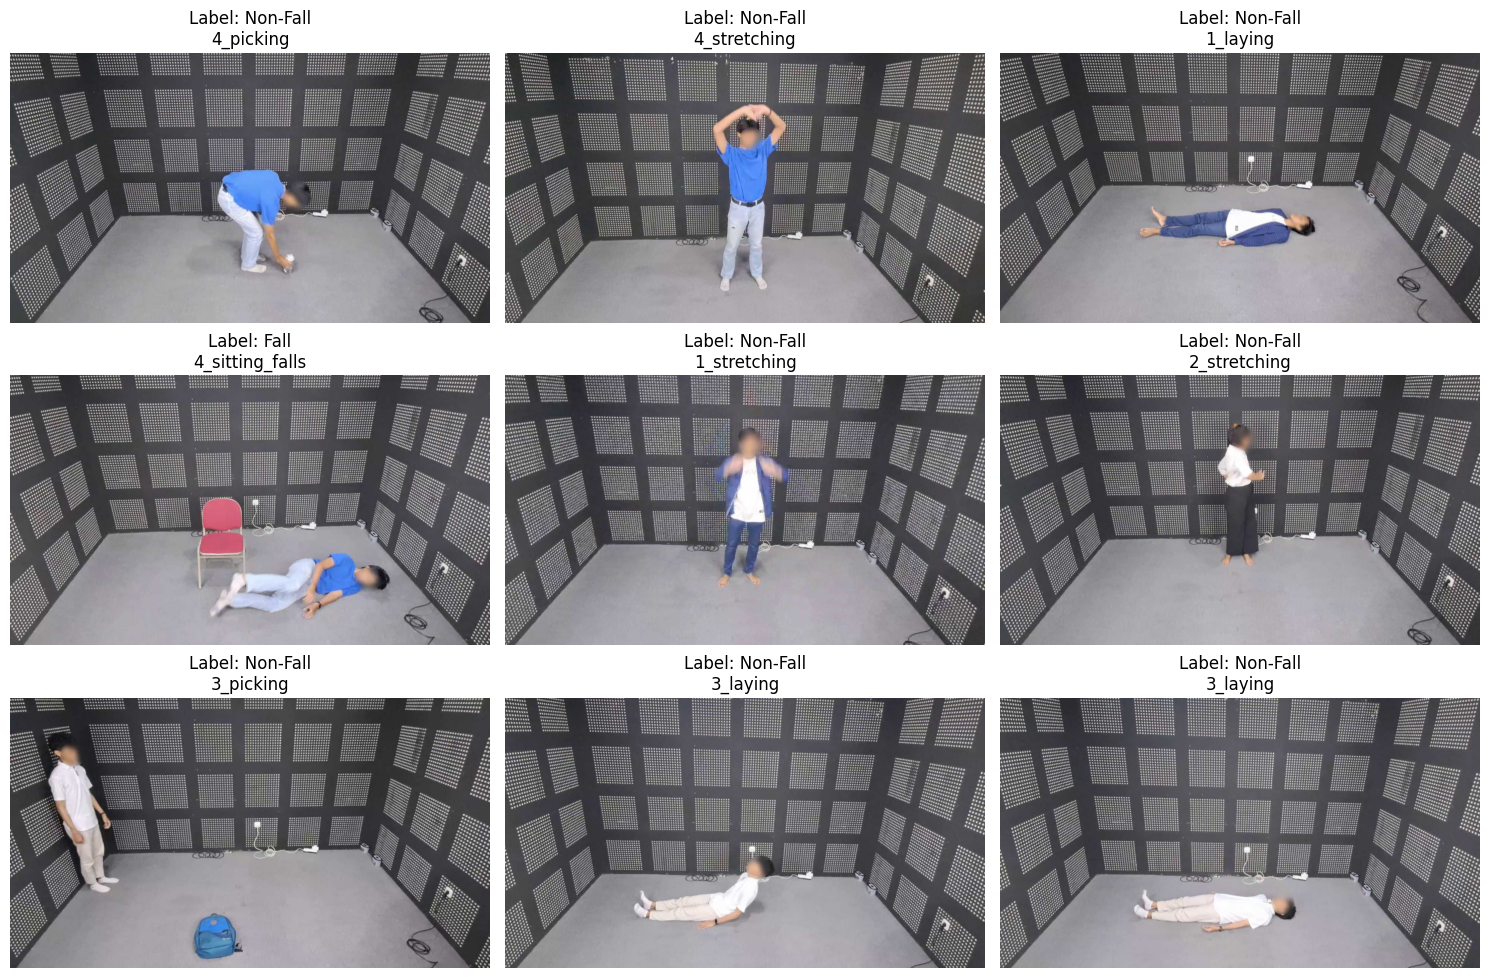

In [19]:
preview(df, "/kaggle/input/data-slayer-2-0-dataset/")

## Hasil Analisis Data

**1. Distribusi Total Sampel**
   - Total sample: 4294 gambar
   - non_fall: 2748 (64.0%)
   - fall: 1546 (36.0%)
   <br>Dataset memiliki ketidakseimbangan (imbalance) kategori dengan jumlah sampel non_fall lebih tinggi dibandingkan dengan fall. Ketidakseimbangan ini dapat menyebabkan model cenderung lebih akurat untuk kategori non_fall, sementara performa untuk kategori fall mungkin kurang optimal</br>
   
**2. Distribusi Berdasarkan Jenis Gerakan (movement_type)**
   - Gerakan non_fall didominasi oleh aktivitas seperti picking (mengambil sesuatu), walking (berjalan), dan stretching (meregangkan badan)
   - Gerakan fall tersebar pada berbagai subkategori seperti sitting falls, right falls, forward falls, backward falls, dan lainnya.
   - Gerakan jatuh lebih variatif dengan banyak tipe, sementara gerakan non_fall memiliki pola yang lebih repetitif (berjalan, jongkok, dan lainnya).
   - Sampel untuk setiap tipe gerakan tidak merata. Misalnya, gerakan seperti backward falls dan left falls memiliki jumlah sampel lebih sedikit dibandingkan dengan picking atau stretching.
     
**3. Distribusi Berdasarkan Subjek (subject)**
   <br>Dataset terdiri dari 4 subjek dengan jumlah sampel sebagai berikut:</br>
   - Subject-1: 885 sampel (20.6%)
   - Subject-2: 918 sampel (21.4%)
   - Subject-3: 1250 sampel (29.1%)
   - Subject-4: 1241 sampel (28.9%)
   - Jumlah sampel dari subjek subject-3 dan subject-4 lebih banyak dibandingkan subject-1 dan subject-2
     
**4. Summary**
- Kategori fall lebih sedikit dibandingkan non_fall
- Terdapat gerakan dengan jumlah sampel kecil, khususnya beberapa jenis gerakan fall seperti backward falls dan left fall
- Subjek tertentu memiliki lebih banyak sampel, yang dapat menyebabkan bias model terhadap subjek tersebut

## Data Preprocessing

In [1]:
train_dir = '/kaggle/input/data-slayer-2-0-dataset/train/'
test_dir = '/kaggle/input/data-slayer-2-0-dataset/test/'

In [21]:
train_dataset = falldetection(train_dir, transform=transform)
test_dataset = falldetection(test_dir, transform=transform, is_test=True)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4294
Number of test samples: 2152


### Hasil Preprocessing

![](https://miro.medium.com/v2/resize:fit:1083/1*onZIiGguLfbUYs3aTtmijg.jpeg)

Transformasi adalah serangkaian prosedur yang diterapkan pada data, terutama gambar, sebelum dimasukkan ke dalam model machine learning atau deep learning. Transformasi ini bertujuan untuk memodifikasi gambar agar sesuai dengan kebutuhan model, baik dalam hal ukuran, format, atau skala nilai piksel. Tujuan utama dari transformasi adalah untuk meningkatkan performa model dengan mengurangi bias, meningkatkan konsistensi, dan mempercepat konvergensi selama pelatihan. Pada kasus ini kami melakukan resize gambar menjadi 350x350 piksel dan selanjutnya menormalkan gambar dengan menggunakan nilai rata-rata (mean) dan deviasi standar (std) untuk setiap saluran warna (RGB)

## Training

In [23]:
print(f"Using device: {DEVICE}")
    
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)  
num_features = model.classifier[1].in_features 
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), 
    nn.Linear(num_features, 1), 
    nn.Sigmoid() 
)
model = model.to(DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 137MB/s] 


### Pemilihan Model

![](https://www.researchgate.net/publication/379104063/figure/fig2/AS:11431281230438611@1710946941115/Architecture-of-EfficientNetV2-9.ppm)

Disini kami menggunakan model pre-train EfficientNetV2 dengan menambahkan beberapa modifikasi kecil, seperti menambahkan lapisan dropout dengan probabilitas 0,3 untuk mencegah overfitting, menggunakan lapisan linear dengan satu neuron keluaran (untuk binary classification task), dan Sigmoid Activation yang digunakan untuk menghasilkan output probabilitas (nilai antara 0 dan 1). Setelah itu, kita pindahkan model ke GPU supaya hasil processingnya bisa lebih cepat. Untuk loss function dan Optimizer kita gunakan Binary Cross-Entropy Loss dan Adam.

In [24]:
train(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    num_epochs=EPOCH, 
    device=DEVICE, 
    accumulation_steps=ACCUMULATION
)

Epoch 1/10, Train Loss: 17.9490, Train Acc: 0.9418
Epoch 2/10, Train Loss: 3.4693, Train Acc: 0.9932
Epoch 3/10, Train Loss: 3.4860, Train Acc: 0.9928
Epoch 4/10, Train Loss: 1.8280, Train Acc: 0.9970
Epoch 5/10, Train Loss: 0.8237, Train Acc: 0.9979
Epoch 6/10, Train Loss: 1.9150, Train Acc: 0.9935
Epoch 7/10, Train Loss: 0.5819, Train Acc: 0.9991
Epoch 8/10, Train Loss: 1.7503, Train Acc: 0.9965
Epoch 9/10, Train Loss: 1.5249, Train Acc: 0.9963
Epoch 10/10, Train Loss: 1.2239, Train Acc: 0.9972


### Hasil Loss dan Accuraccy

Nilai loss yang lebih tinggi pada awal training (misalnya, 17.9490 pada epoch pertama) menunjukkan bahwa model masih sangat jauh dari prediksi yang benar. Namun, setelah beberapa epoch, nilai loss mulai menurun secara signifikan, yang menunjukkan bahwa model semakin belajar dan memperbaiki prediksinya. Lalu untuk accuraccy pada epoch pertama, akurasi model sudah sangat tinggi, yakni 94.18%. Kemudian, akurasi terus meningkat, mencapai 99.91% pada epoch ke-7, dan meskipun ada fluktuasi sedikit (misalnya, pada epoch ke-6 akurasi turun menjadi 99.35%), pada akhirnya model mempertahankan akurasi yang sangat tinggi (sekitar 99.72% pada epoch ke-10).

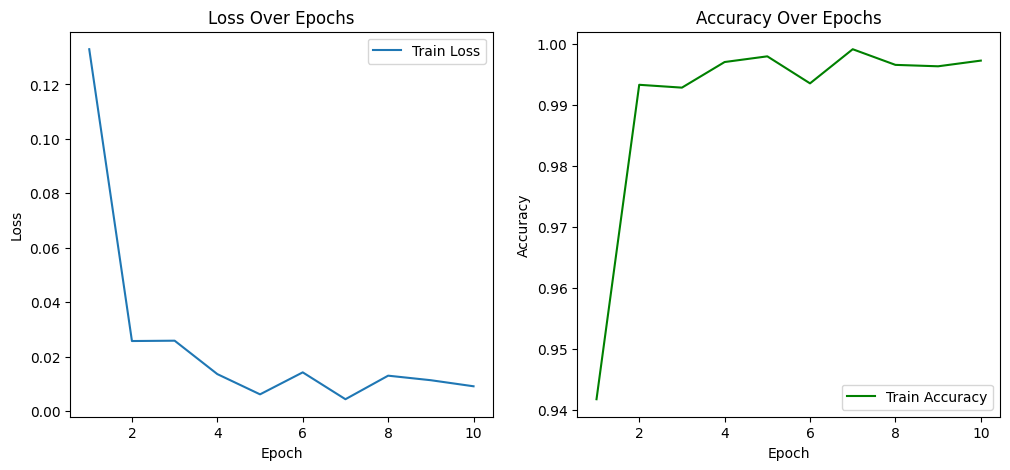

In [25]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCH + 1), train_losses, label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCH + 1), train_accuracies, label='Train Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Hasil dari Grafik

Grafik yang ditampilkan menunjukkan performa model selama proses pelatihan berdasarkan dua metrik utama: loss dan akurasi. Pada grafik "Loss Over Epochs", terlihat bahwa nilai loss mengalami penurunan yang konsisten dari sekitar 0,12 pada epoch pertama hingga mendekati nol di epoch ke-10. Hal ini menunjukkan bahwa model berhasil mempelajari pola pada data training dengan baik dan secara bertahap meminimalkan kesalahan prediksinya. Sementara itu, pada grafik "Accuracy Over Epochs", akurasi model meningkat secara tajam di epoch awal, dari sekitar 94% menjadi hampir 100% hanya dalam beberapa epoch, dan tetap stabil di kisaran 99%-100% hingga akhir pelatihan.

## Prediction

In [26]:
checkpoint_path = '/kaggle/working/model.h5'
model.load_state_dict(torch.load(checkpoint_path))
print(f"Model loaded from {checkpoint_path}")

Model loaded from /kaggle/working/model.h5


/tmp/ipykernel_23/3607791117.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [27]:
image_names, test_predictions = test(model, test_loader, DEVICE)
print(f"Number of test predictions: {len(test_predictions)}")

Number of test predictions: 2152


In [28]:
if len(image_names) == len(test_predictions):
    submission = pd.DataFrame({
        'id': image_names,
        'label': test_predictions
    })

    submission.to_csv('sub.csv', index=False)
    print("Success")
else:
    print("Error")

Success


### Kesimpulan
Berdasarkan hasil analisis dan eksperimen yang dilakukan pada dataset human fall, dapat disimpulkan bahwa model yang digunakan, yaitu EfficientNetV2 yang telah dimodifikasi dengan menambahkan lapisan dropout dan menggunakan binary cross-entropy loss, menunjukkan performa yang sangat baik. Transformasi data yang dilakukan, seperti resize dan normalisasi gambar, berhasil menyiapkan data secara optimal untuk diproses oleh model. Meskipun terdapat ketidakseimbangan dalam jumlah sampel untuk kategori fall dan non_fall, serta variasi jumlah sampel berdasarkan jenis gerakan dan subjek, model tetap dapat mempelajari pola dengan baik.

Selama proses pelatihan, model mengalami penurunan loss yang signifikan dan peningkatan akurasi yang stabil. Di awal pelatihan, model sudah menunjukkan akurasi yang sangat tinggi (94,18%), dan setelah 10 epoch, akurasi mencapai 99,72%. Grafik yang menunjukkan penurunan loss dan peningkatan akurasi mencerminkan kemampuan model untuk belajar dan mengoptimalkan prediksinya dengan sangat cepat. Hasil akhir pada Kaggle Score menunjukkan nilai public score sebesar 0.97058823, yang menggambarkan bahwa model ini memiliki kinerja yang sangat baik dalam mengklasifikasikan gambar human fall